In [176]:
"""
@author Rahul Gupta
"""

import string
import re
import tweepy
import twitterClient

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon

from colorama import Fore, Style
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

def countWordSentimentAnalysis(setPosWords, setNegWords, tweets, tweetProcessor):

    lSentiment = []

    for tweet in tweets:
        try:
            tweetText = tweet['text']
            tweetDate = tweet['created_at']

            lTokens = tweetProcessor.process(tweetText)
            sentiment = computeSentiment(lTokens, setPosWords, setNegWords)
            lSentiment.append([pd.to_datetime(tweetDate),tweetText, sentiment])

        except KeyError as e:
            pass

    return lSentiment



def vaderSentimentAnalysis(tweets, bPrint, tweetProcessor):

    sentAnalyser = SentimentIntensityAnalyzer()

    lSentiment = []

    for tweet in tweets:
        try:
            tweetText = tweet['text']
            tweetDate = tweet['created_at']

            lTokens = tweetProcessor.process(tweetText)

            dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))

            lSentiment.append([pd.to_datetime(tweetDate), tweetText, dSentimentScores['compound']])

            if bPrint:
                print(*lTokens, sep=', ')
                for cat,score in dSentimentScores.items():
                    print('{0}: {1}, '.format(cat, score), end='')
                print()

        except KeyError as e:
            pass

    return lSentiment


def computeSentiment(lTokens, setPosWords, setNegWords):
    pos_words = 0
    neg_words = 0
    
    if lTokens in setPosWords:
        pos_words += 1
    elif lTokens in setNegWords:
        neg_words += 1
    else:
        pass

    if pos_words > neg_words:
        return('Positive')
    elif pos_words < neg_words:
        return('Negative')
    elif pos_words == neg_words:
        return('Neutral')


class TwitterProcessing:

    def __init__(self, tokeniser, lStopwords):
        self.tokeniser = tokeniser
        self.lStopwords = lStopwords

    def process(self, text):

        text = text.lower()
        tokens = self.tokeniser.tokenize(text)
        tokensStripped = [tok.strip() for tok in tokens]
        regexDigit = re.compile("^\d+\s|\s\d+\s|\s\d+$")
        regexHttp = re.compile("^http")

        return [tok for tok in tokensStripped if tok not in self.lStopwords and
                regexDigit.match(tok) == None and regexHttp.match(tok) == None]


def remove_duplicates(l):
    return list(set(l))


In [180]:
api = twitterClient.twitter_client()

tweets = []
query = 'streaming service OR streaming movies OR streaming series'
max_tweets = 3000

# append all tweet data to list
for tweet in tweepy.Cursor(api.search, q=query, lang="en").items(max_tweets):
    tweets.append(tweet._json)

tweetTokenizer = TweetTokenizer()
lPunct = list(string.punctuation)
lStopwords = stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", '`']

tweetProcessor = TwitterProcessing(tweetTokenizer, lStopwords)

setPosWords = opinion_lexicon.positive()
setNegWords = opinion_lexicon.negative()

# lSentiment = vaderSentimentAnalysis(args.tweetsFile, args.print, tweetProcessor)

TweepError: Twitter error response: status code = 429

In [175]:
lSentiment = []
lSentiment = countWordSentimentAnalysis(setPosWords, setNegWords, tweets, tweetProcessor)

In [172]:
df = pd.DataFrame(lSentiment)
df.columns = ['Timestamp', 'text','Sentiment']
df

,Timestamp,text,Sentiment
0,2018-05-13 11:07:12,RT @shen_ilovemusic: @clcrke Don't give up! No...,Neutral
1,2018-05-13 11:06:00,Jon Favreau’s Star Wars series will be set bet...,Neutral
2,2018-05-13 10:53:12,RT @lalalalinder: Jon Favreau’s Star Wars seri...,Neutral
3,2018-05-13 10:47:18,Jon Favreau’s Star Wars series will be set bet...,Neutral
4,2018-05-13 10:35:43,RT @shen_ilovemusic: @clcrke Don't give up! No...,Neutral
5,2018-05-13 10:30:20,RT @Techmeme: Sources: Jeffrey Katzenberg secu...,Neutral
6,2018-05-13 10:28:17,RT @debbie_day: @JamesSACorey If any series de...,Neutral
7,2018-05-13 10:05:09,Jon Favreau’s Star Wars series will be set bet...,Neutral
8,2018-05-13 10:04:10,Movie Popular and TV Series This Month\nWatch ...,Neutral
9,2018-05-13 10:02:04,Watch Full HD Movie Streaming\nPopular Movie A...,Neutral


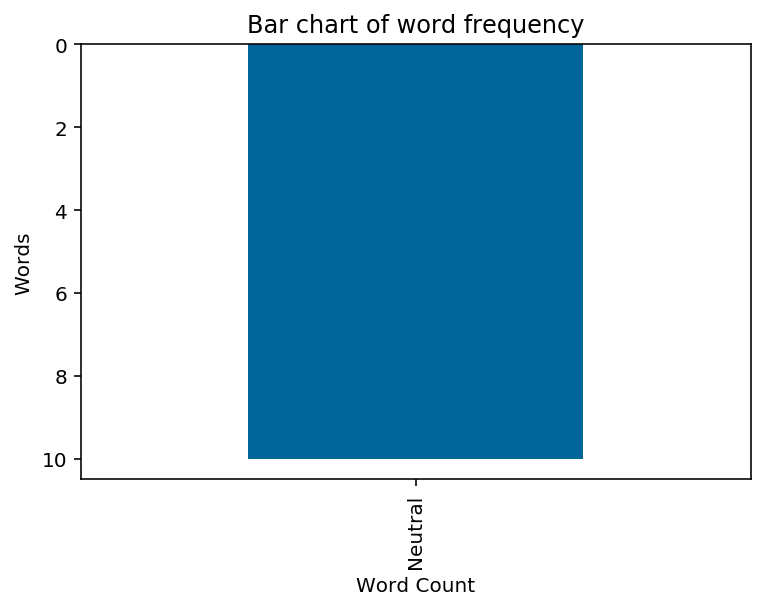

In [179]:
freq = df.groupby(['Sentiment']).size().reset_index(name='counts')
freq.sort_values(['counts'], ascending=False, inplace=True)
freq = freq.head(20)

freq.plot(kind='bar',x='Sentiment',y='counts', color='#006699')
ax = plt.gca().invert_yaxis()
plt.xlabel('Word Count')
plt.ylabel('Words')
plt.title('Bar chart of word frequency')
plt.legend().set_visible(False)